In [1]:
import torch
from torch import nn
import math

class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, max_len: int = 1000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)
        div = torch.exp(torch.arange(0, d_model, 2, dtype=torch.float32) * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(pos * div)
        pe[:, 1::2] = torch.cos(pos * div)
        self.register_buffer("pe", pe.unsqueeze(0))

    def forward(self, x):
        return x + self.pe[:, : x.size(1)]

# TransformerTimeSeriesModel class

In [2]:
from torch import nn
import torch

class TransformerTimeSeriesModel(nn.Module):
    def __init__(
        self,
        input_size: int,
        d_model: int,
        nhead: int,
        num_layers: int,
        dim_feedforward: int,
        dropout: float,
        context_length: int,
        prediction_length: int,
        output_variance: bool = True,
    ):
        super().__init__()
        self.context_length = context_length
        self.prediction_length = prediction_length
        self.d_model = d_model
        self.output_variance = output_variance

        self.input_proj = nn.Linear(input_size, d_model)
        self.pos_enc = PositionalEncoding(d_model, max_len=context_length)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True,
            norm_first=True,
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        out_dim = prediction_length * (2 if output_variance else 1)
        self.head = nn.Linear(d_model * context_length, out_dim)

    def forward(self, x):
        h = self.input_proj(x)
        h = self.pos_enc(h)
        h = self.encoder(h)
        h_flat = h.view(h.size(0), -1) # Before: h_last = h[:, -1, :]
        out = self.head(h_flat) # Before: self.head(h_last)

        if self.output_variance:
            mean, log_var = out.chunk(2, dim=-1)
            mean = mean.view(-1, self.prediction_length)
            log_var = log_var.view(-1, self.prediction_length)
            return mean, log_var.clamp(-7, 7)
        else:
            mean = out.view(-1, self.prediction_length)
            return mean, None

# PositionalEncoding class

In [3]:
# TransformerACPIWrapper class
import torch
import numpy as np

class TransformerACPIWrapper:
    """
    ACPI wrapper expects tabular X. We flatten (T * F) -> (T,F) for transformer.
    """
    def __init__(self, transformer_model, device, context_length, num_features, prediction_length):
        self.model = transformer_model
        self.device = device
        self.context_length = context_length
        self.num_features = num_features
        self.prediction_length = prediction_length
        self.model.eval()

    def _unflatten(self, X_flat):
        return X_flat.reshape(X_flat.shape[0], self.context_length, self.num_features)

    def predict(self, X):
        """
        X: (N, context_length * num_features) flattened windows
        Returns: mean predictions (N,)
        """
        X_seq = self._unflatten(X)
        X_tensor = torch.from_numpy(X_seq).float().to(self.device)
        with torch.no_grad():
            mean, _ = self.model(X_tensor)
        return mean.cpu().numpy().flatten()

# Multi-feature Transformer + ACPI pipeline

In [4]:
import math
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [5]:
def read_data(path):
    df = pd.read_csv(path, parse_dates=["datetime"])
    df = df.sort_values("datetime").set_index("datetime")
    df["holiday"] = df["holiday"].astype(int)
    df["workingday"] = df["workingday"].astype(int)
    # Time features
    df["hour"] = df.index.hour
    df["day_of_week"] = df.index.dayofweek
    df["month"] = df.index.month
    # Cyclical encodings
    df["hour_sin"] = np.sin(2 * np.pi * df["hour"] / 24)
    df["hour_cos"] = np.cos(2 * np.pi * df["hour"] / 24)
    df["dow_sin"] = np.sin(2 * np.pi * df["day_of_week"] / 7)
    df["dow_cos"] = np.cos(2 * np.pi * df["day_of_week"] / 7)
    df = df.fillna(method="ffill").fillna(method="bfill")
    return df

train_df = read_data("data/train.csv")
test_df = read_data("data/test.csv")

target_col = "count"

# Select feature columns (exclude target if present)
base_feature_cols = [c for c in train_df.columns if c != target_col]

feature_cols = base_feature_cols  # can prune or reorder

print("Num features:", len(feature_cols), feature_cols)


Num features: 17 ['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'hour', 'day_of_week', 'month', 'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos']


C:\Users\joobzm\AppData\Local\Temp\ipykernel_17556\1407533118.py:15: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method="ffill").fillna(method="bfill")
C:\Users\joobzm\AppData\Local\Temp\ipykernel_17556\1407533118.py:15: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method="ffill").fillna(method="bfill")


In [6]:
# After reading and feature engineering both dataframes and defining target_col
all_train_feats = [c for c in train_df.columns if c != target_col]
all_test_feats = list(test_df.columns)  # test has no target, nor casual/registered

# Keep only columns present in both
shared_feats = [c for c in all_train_feats if c in all_test_feats]

# (Optional) add engineered features that exist in both (they were added symmetrically in read_data)
feature_cols = shared_feats

# Report dropped columns (e.g. casual, registered)
dropped = sorted(set(all_train_feats) - set(feature_cols))
if dropped:
    print("Dropped train-only columns (not in test):", dropped)

print("Num features:", len(feature_cols))
print("Feature columns:", feature_cols)

# Fit / transform
scaler = StandardScaler()
train_features = scaler.fit_transform(train_df[feature_cols].values.astype(np.float32))
test_features = scaler.transform(test_df[feature_cols].values.astype(np.float32))
train_target = train_df[target_col].values.astype(np.float32)

Dropped train-only columns (not in test): ['casual', 'registered']
Num features: 15
Feature columns: ['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp', 'humidity', 'windspeed', 'hour', 'day_of_week', 'month', 'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos']


In [7]:
def create_sequences_multifeature(features, target, context_length, prediction_length):
    X_list, y_list = [], []
    for i in range(len(target) - context_length - prediction_length + 1):
        X_window = features[i:i+context_length]          # (T, F)
        y_window = target[i+context_length:i+context_length+prediction_length]  # (H,)
        X_list.append(X_window)
        y_list.append(y_window)
    X = np.stack(X_list)  # (N, T, F)
    y = np.stack(y_list)  # (N, H)
    return X.astype(np.float32), y.astype(np.float32)

context_length = 24
prediction_length = 1

X_all, y_all = create_sequences_multifeature(
    train_features, train_target, context_length, prediction_length
)

num_features = X_all.shape[-1]
print("Sequence tensor shape:", X_all.shape, "Target shape:", y_all.shape)


Sequence tensor shape: (10862, 24, 15) Target shape: (10862, 1)


In [8]:
class EarlyStopping:
    """
    Monitors a scalar (e.g.\ validation loss) and triggers stop after no improvement
    for `patience` epochs. Supports restoring best weights.
    """
    def __init__(self, patience=15, min_delta=0.0, mode="min", restore_best=True):
        self.patience = patience
        self.min_delta = min_delta
        self.mode = mode
        self.restore_best = restore_best
        self.best = None
        self.counter = 0
        self.best_state = None
        if mode not in ("min", "max"):
            raise ValueError("mode must be 'min' or 'max'")

    def _is_better(self, current):
        if self.best is None:
            return True
        if self.mode == "min":
            return current < self.best - self.min_delta
        else:
            return current > self.best + self.min_delta

    def step(self, current, model):
        if self._is_better(current):
            self.best = current
            self.counter = 0
            if self.restore_best:
                self.best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
        else:
            self.counter += 1
        return self.counter >= self.patience

    def restore(self, model):
        if self.restore_best and self.best_state is not None:
            model.load_state_dict(self.best_state)

<>:3: SyntaxWarning: invalid escape sequence '\ '
<>:3: SyntaxWarning: invalid escape sequence '\ '
C:\Users\joobzm\AppData\Local\Temp\ipykernel_17556\1819731118.py:3: SyntaxWarning: invalid escape sequence '\ '
  Monitors a scalar (e.g.\ validation loss) and triggers stop after no improvement


In [9]:
# Split for transformer training (keep tail for ACPI)
train_ratio = 0.8
n_train = int(len(X_all) * train_ratio)
X_tr_model, X_hold = X_all[:n_train], X_all[n_train:]
y_tr_model, y_hold = y_all[:n_train], y_all[n_train:]

train_ds = TensorDataset(torch.from_numpy(X_tr_model), torch.from_numpy(y_tr_model))
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)


In [10]:
# Hyperparameters
d_model = 96
nhead = 4
num_layers = 3
dim_feedforward = 256
dropout = 0.1
lr = 2e-4
epochs = 200
output_variance = True


In [11]:
# Training utilities
def gaussian_nll(mean, log_var, target):
    var = torch.exp(log_var)
    return 0.5 * (log_var + (target - mean)**2 / var + math.log(2 * math.pi))


In [12]:
# Train function
def train_model(model, loader, epochs, optimizer):
    model.train()
    for ep in range(1, epochs + 1):
        total = 0.0
        for xb, yb in loader:
            xb = xb.to(device)
            yb = yb.to(device)
            optimizer.zero_grad()
            mean, log_var = model(xb)
            if log_var is not None:
                loss = gaussian_nll(mean, log_var, yb).mean()
            else:
                loss = nn.MSELoss()(mean, yb)
            loss.backward()
            optimizer.step()
            total += loss.item()
        if ep % 5 == 0 or ep == 1 or ep == epochs:
            print(f"Epoch {ep}/{epochs} - Loss: {total/len(loader):.4f}")


In [13]:
# Prepare ACPI splits from hold set
def prepare_acpi_from_hold(X_seq, y_seq, cal_split=0.5, test_split=0.3):
    # Flatten across context for ACPI tabular input
    X_flat = X_seq.reshape(X_seq.shape[0], -1)
    n_total = X_flat.shape[0]
    n_test = int(n_total * test_split)
    X_temp, X_test = X_flat[:-n_test], X_flat[-n_test:]
    y_temp, y_test = y_seq[:-n_test], y_seq[-n_test:]
    n_cal = int(len(X_temp) * cal_split)
    X_train_acpi, X_cal = X_temp[:-n_cal], X_temp[-n_cal:]
    y_train_acpi, y_cal = y_temp[:-n_cal], y_temp[-n_cal:]
    return X_train_acpi, X_cal, X_test, y_train_acpi.squeeze(), y_cal.squeeze(), y_test.squeeze()

X_train_acpi, X_cal, X_test, y_train_acpi, y_cal, y_test = prepare_acpi_from_hold(X_hold, y_hold)

print("ACPI shapes:", X_cal.shape, X_test.shape)


ACPI shapes: (761, 360) (651, 360)


In [14]:
# Instantiate model
# (Classes defined in later cells)
model = TransformerTimeSeriesModel(
    input_size=num_features,
    d_model=d_model,
    nhead=nhead,
    num_layers=num_layers,
    dim_feedforward=dim_feedforward,
    dropout=dropout,
    context_length=context_length,
    prediction_length=prediction_length,
    output_variance=output_variance,
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)


C:\Users\joobzm\Desktop\TDK\ACPI\.venv\Lib\site-packages\torch\nn\modules\transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


In [15]:
train_model(model, train_loader, epochs, optimizer)
print("Transformer training done.")


Epoch 1/200 - Loss: 321.4766
Epoch 5/200 - Loss: 27.9622
Epoch 10/200 - Loss: 22.1353
Epoch 15/200 - Loss: 16.8142
Epoch 20/200 - Loss: 16.0203
Epoch 25/200 - Loss: 14.8923
Epoch 30/200 - Loss: 11.4923
Epoch 35/200 - Loss: 10.1498
Epoch 40/200 - Loss: 7.7461
Epoch 45/200 - Loss: 6.5873
Epoch 50/200 - Loss: 6.2025
Epoch 55/200 - Loss: 6.0501
Epoch 60/200 - Loss: 5.8665
Epoch 65/200 - Loss: 5.7447
Epoch 70/200 - Loss: 5.5400
Epoch 75/200 - Loss: 5.3622
Epoch 80/200 - Loss: 5.2143
Epoch 85/200 - Loss: 5.0685
Epoch 90/200 - Loss: 4.9604
Epoch 95/200 - Loss: 4.9015
Epoch 100/200 - Loss: 4.7473
Epoch 105/200 - Loss: 4.6862
Epoch 110/200 - Loss: 4.6385
Epoch 115/200 - Loss: 4.5563
Epoch 120/200 - Loss: 4.5177
Epoch 125/200 - Loss: 4.4784
Epoch 130/200 - Loss: 4.4172
Epoch 135/200 - Loss: 4.3854
Epoch 140/200 - Loss: 4.3440
Epoch 145/200 - Loss: 4.3006
Epoch 150/200 - Loss: 4.2881
Epoch 155/200 - Loss: 4.2303
Epoch 160/200 - Loss: 4.2294
Epoch 165/200 - Loss: 4.1834
Epoch 170/200 - Loss: 4.151

In [23]:
# save model
torch.save(model.state_dict(), "transformer_model.pth")

In [16]:
# Wrap model for ACPI
wrapper = TransformerACPIWrapper(
    transformer_model=model,
    device=device,
    context_length=context_length,
    num_features=num_features,
    prediction_length=prediction_length,
)


In [17]:
from acpi import ACPI
from acpi.utils import compute_coverage

alpha = 0.1
acpi = ACPI(
    model_cali=wrapper,
    n_estimators=200,
    max_depth=25,
    min_node_size=15
)

# Fit ACPI (QRF)
acpi.fit(X_cal, y_cal, nonconformity_func=None)
acpi.fit_calibration(X_cal, y_cal, nonconformity_func=None, quantile=1-alpha, only_qrf=True)

y_lower, y_upper = acpi.predict_pi(X_test, method="qrf")
coverage = compute_coverage(y_test, y_lower, y_upper)
print(f"ACPI coverage: {coverage:.4f} | Target: {1-alpha:.4f}")


100%|██████████| 50/50 [02:34<00:00,  3.09s/it]


ACPI coverage: 0.9555 | Target: 0.9000


In [18]:
# Compare raw transformer point forecasts (mean)
with torch.no_grad():
    X_test_3d = X_test.reshape(X_test.shape[0], context_length, num_features)
    preds_mean, _ = model(torch.from_numpy(X_test_3d).float().to(device))
    preds_mean = preds_mean.cpu().numpy().squeeze()


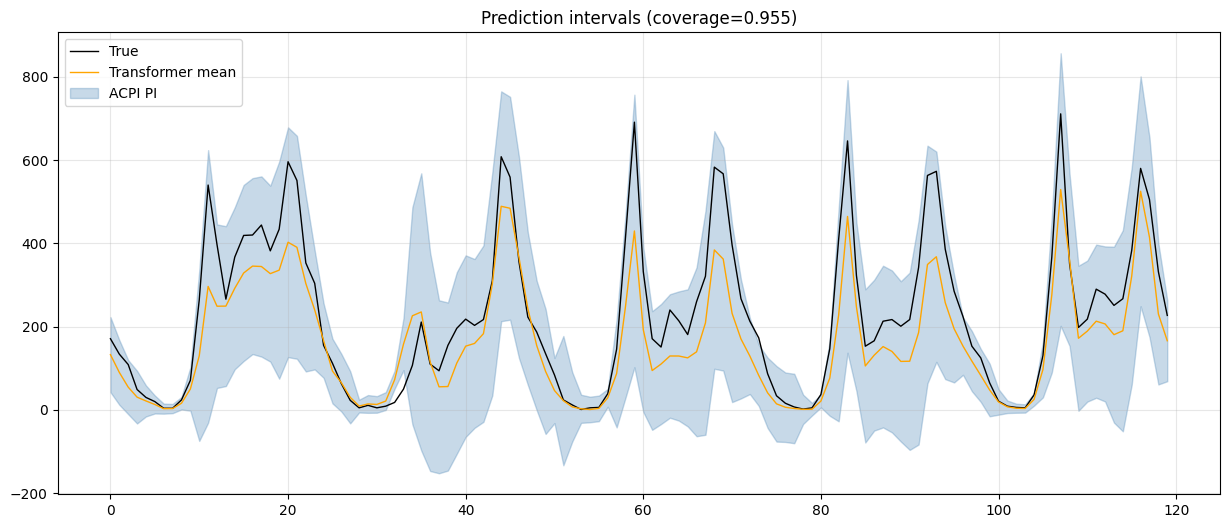

In [19]:
n_plot = min(120, len(y_test))
idx = np.arange(n_plot)
plt.figure(figsize=(15,6))
plt.plot(idx, y_test[:n_plot], label="True", color="black", linewidth=1)
plt.plot(idx, preds_mean[:n_plot], label="Transformer mean", color="orange", linewidth=1)
plt.fill_between(idx, y_lower[:n_plot], y_upper[:n_plot], color="steelblue", alpha=0.3, label="ACPI PI")
plt.title(f"Prediction intervals (coverage={coverage:.3f})")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


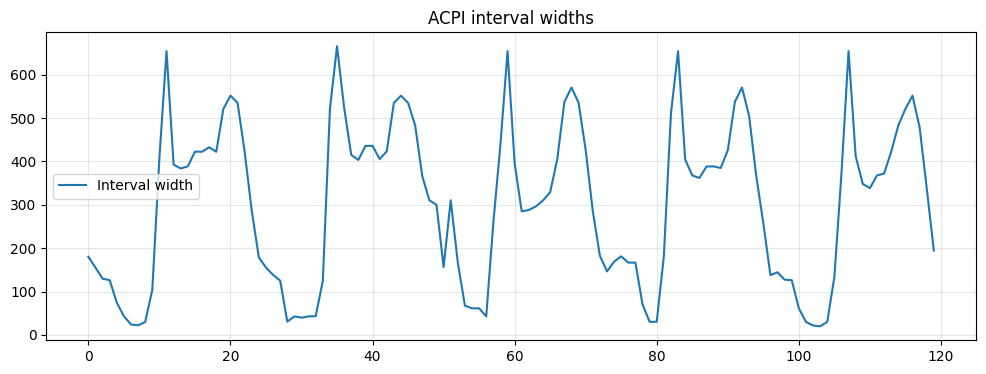

In [20]:
interval_widths = y_upper - y_lower
plt.figure(figsize=(12,4))
plt.plot(interval_widths[:n_plot], label="Interval width")
plt.legend(); plt.grid(alpha=0.3); plt.title("ACPI interval widths")
plt.show()


In [21]:
n_below = (y_test < y_lower).sum()
n_above = (y_test > y_upper).sum()
n_within = ((y_test >= y_lower) & (y_test <= y_upper)).sum()
total = len(y_test)
print(f"Below: {n_below} ({n_below/total:.2%}) | Above: {n_above} ({n_above/total:.2%}) | Within: {n_within} ({n_within/total:.2%})")


Below: 2 (0.31%) | Above: 27 (4.15%) | Within: 622 (95.55%)


In [22]:
print("Done.")

Done.
